In [25]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import random
mi.set_variant('cuda_ad_rgb')

In [26]:
sensor_count = 1
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 256 * sensor_count, 'height': 256,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    }
}

In [320]:
spot_light_1 = {'type': 'spot',
                'to_world': mi.ScalarTransform4f.look_at(
                    origin=[-1.0, 0.05, -0.25],
                    target=[0, -0.2, 0],
                    up=[0, 1, 0]
                ),
                'intensity': {
                    'type': 'spectrum',
                    'value': 10.0,
                }
            }

In [321]:
spot_light_2 = {'type': 'spot',
                'to_world': mi.ScalarTransform4f.look_at(
                    origin=[0.9, -0.15, -0.25],
                    target=[0, 0, 0],
                    up=[0, 1, 0]
                ),
                'intensity': {
                    'type': 'spectrum',
                    'value': 10.0,
                }
            }

In [322]:
spot_light_3 = {'type': 'spot',
                'to_world': mi.ScalarTransform4f.look_at(
                    origin=[0.0, -1, 3],
                    target=[0, 0, 0],
                    up=[0, 1, 0]
                ),
                'intensity': {
                    'type': 'spectrum',
                    'value': 10.0,
                }
            }

In [338]:
mi.cornell_box()

{'type': 'scene',
 'integrator': {'type': 'path', 'max_depth': 8},
 'sensor': {'type': 'perspective',
  'fov_axis': 'smaller',
  'near_clip': 0.001,
  'far_clip': 100.0,
  'focus_distance': 1000,
  'fov': 39.3077,
  'to_world': [[-1, 0, 0, 0],
   [0, 1, 0, 0],
   [0, 0, -1, 3.9],
   [0, 0, 0, 1]],
  'sampler': {'type': 'independent', 'sample_count': 64},
  'film': {'type': 'hdrfilm',
   'width': 256,
   'height': 256,
   'rfilter': {'type': 'gaussian'},
   'pixel_format': 'rgb',
   'component_format': 'float32'}},
 'white': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.885809, 0.698859, 0.666422]}},
 'green': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.105421, 0.37798, 0.076425]}},
 'red': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.570068, 0.0430135, 0.0443706]}},
 'light': {'type': 'rectangle',
  'to_world': [[0.23, 0, 0, 0],
   [0, -8.30516e-09, -0.19, 0.99],
   [0, 0.19, -8.30516e-09, 0.01],
   [0, 0, 0, 1]],
  'bsdf': {'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


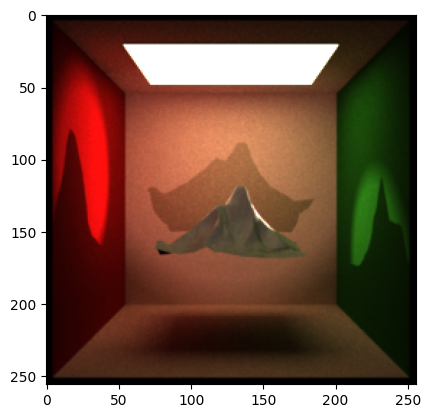

In [337]:
from mitsuba import ScalarTransform4f as T

scene_dict = mi.cornell_box()
del scene_dict['small-box']
del scene_dict['large-box']
# del scene_dict['light']
scene_dict['light']['to_world'] @= T.scale(mi.ScalarPoint3f(3.0, 3.0, 3.0))
scene_dict['light']['emitter']['radiance']['value'] = mi.ScalarPoint3f(3, 3, 2)
scene_dict['light2'] = spot_light_1
scene_dict['light3'] = spot_light_2
scene_dict['light4'] = spot_light_3

scene_dict['heightfield'] = {
        'type': 'heightfield',
        'filename': 'data/depth.bmp',
        'max_height': 1.0,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
          },
        'to_world': T.translate(mi.ScalarPoint3f(0.0, -0.4, 0.0)) @ T.rotate(mi.ScalarPoint3f(1.0, 0.0, 0.0), (-90)) @ T.scale(mi.ScalarPoint3f(0.5, 0.5, 0.5))
        }
scene = mi.load_dict(scene_dict)
img = mi.render(scene, spp=1024)
plt.imshow(img)

In [307]:
# Generate random viewpoints in upper hemispher
def random_upper_hemisphere(u, v, r):
    theta = u * (dr.pi / 4) + (dr.pi/4)
    phi = (v * dr.pi * 2) - dr.pi

    x = r * dr.sin(theta) * dr.cos(phi)
    y = r * dr.sin(theta) * dr.sin(phi)
    z = r * dr.cos(theta)
    return x, y, z

In [28]:
from mitsuba import ScalarTransform4f as T

origins = []
for i in range(sensor_count):
    d = 4
    u = random.uniform(0, 1)
    v = random.uniform(0, 1)
    x_v, y_v, z_v = random_upper_hemisphere(u, v, d)

    origin = mi.ScalarPoint3f(x_v, y_v, z_v)
    origins.append(origin)

    sensor[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=origin, up=[0, 0, 1])
    }

In [29]:
scene_dict_ref = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sensor': sensor,
    'sphere_2': {
        'type': 'sphere',
        'center': [0, 0, 5],
        'radius': 1,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 30.0,
            }
        }
    },
    'heightfield': {
        'type': 'heightfield',
        'filename': 'data/depth.bmp',
        'max_height': 1.0,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    }
}

scene_target = mi.load_dict(scene_dict_ref)

In [30]:
params = mi.traverse(scene_target)

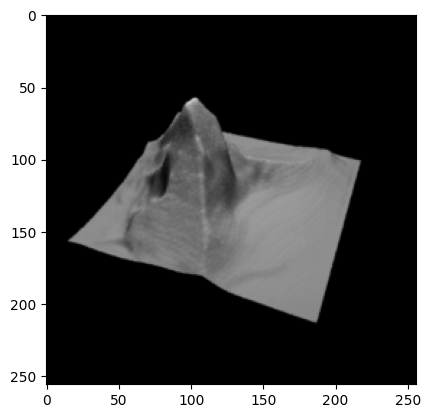

In [31]:
img = mi.render(scene_target, spp=16)
plt.imshow(img)

In [34]:
params['heightfield.heightfield'] *= 1.5
params.update()

[(Heightfield[
    to_world = [[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]],
    max height = 1,
    surface_area = [0],
    bsdf = SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.5, 0.5, 0.5]]
      ]
    ]
  ],
  {'heightfield'}),
 (Scene[
    children = [
      Heightfield[
        to_world = [[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]],
        max height = 1,
        surface_area = [0],
        bsdf = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.5, 0.5, 0.5]]
          ]
        ]
      ],
      DirectReparamIntegrator[max_depth = 6, rr_depth = 5],
      BatchSensor[0x7fc71000d530],
      Sphere[
        to_world = [[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 5],
                    [0, 0, 0, 1]],
        center = [0, 0, 5],
        radius = 1,


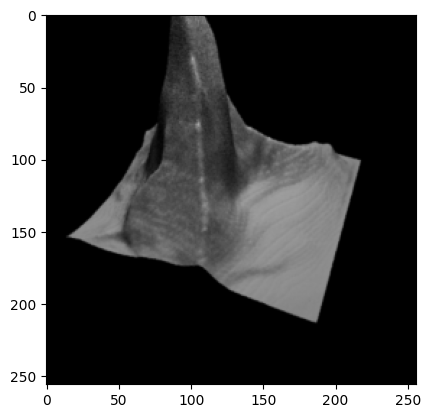

In [35]:
img = mi.render(scene_target, spp=16)
plt.imshow(img)